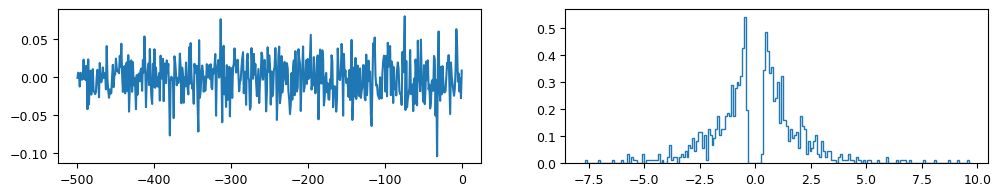

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from joblib import Parallel, delayed
from ssms.basic_simulators.simulator import simulator
from statsmodels.tsa.stattools import acf

from drift_diffusion.model import DriftDiffusionModel, pdf

# notebook setting
seed = 0
rng = np.random.default_rng(seed=seed)
z_to_ssm = lambda z: (z + 1) / 2

# simulation setting
n_samples, n_repeats = 1_000, 900
coh = rng.uniform(-1, 1, size=n_samples)
params = {"a": 1.37, "t0": 0.3}

# simulate win-stay, lose-switch
ys = np.zeros((n_samples, n_repeats))
z_t = np.zeros(n_repeats)  # starting bias
for t in range(n_samples):

    # sim trial t
    v_t = 1 * coh[t]
    sim_params = {"a": params["a"], "t": params["t0"], "v": v_t, "z": z_to_ssm(z_t)}
    sims = simulator(model="ddm", theta=sim_params, n_samples=1, smooth_unif=False, random_state=t)
    y_t = np.squeeze(sims["rts"] * sims["choices"])  # shape (n_repeats, )

    # store trial t (all repeats)
    ys[t] = y_t

    # update z per repeat (win-stay / lose-switch)
    choice_t = np.sign(y_t)
    is_correct = np.sign(coh[t]) == choice_t
    z_t = np.where(is_correct, +0.5 * choice_t, -0.5 * choice_t)

# plot example (pick one repeat to view)
n_lags = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 2))
axs[0].plot(-np.arange(n_lags), acf(ys[:, 1], nlags=n_lags)[1:])
axs[1].hist(ys[:, 1], bins=200, histtype="step", density=True)
pass

In [2]:
# initlaize ddm
X = pd.DataFrame({"coh": coh})
ddm = DriftDiffusionModel(t0=params["t0"], v="-1+coh", cov_estimator="all")
param_names = ["a", "v", "z"]
cov_names = [f"{i},{j}" for i in param_names for j in param_names]


@delayed
def run_simulation(rep):
    ddm.fit(X, ys[:, rep])
    covs_ = [
        {"estimator": k, **{cov_names[i]: val for i, val in enumerate(utils.cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, covs_


with Parallel(n_jobs=-4) as parallel:
    results = parallel(run_simulation(rep) for rep in range(n_repeats))

params_, covs_ = zip(*results)
params_df = pd.DataFrame(params_, columns=param_names)
covs_df = pd.DataFrame([row for c in covs_ for row in c])

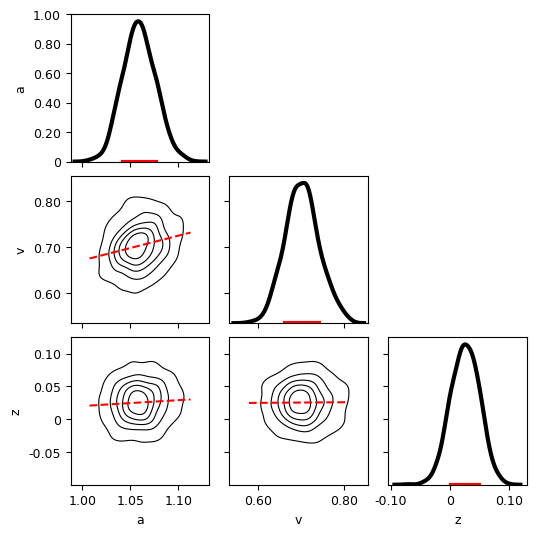

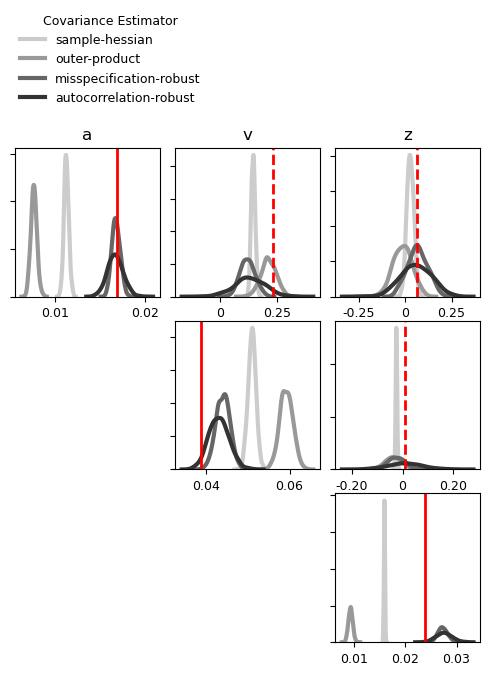

In [3]:
utils.plot_parameter_distributions(params_df, None)
utils.plot_covariance_distributions(covs_df, params_df, param_names)